# Training Transformer (ML2025 Homework4)

In this homework, we train the Mistral's transformer model. Next, we will use it to predict the pokemon images based on the top $2/3$ of the images.

# Utilities

### Download packages

In [16]:
!pip install datasets==3.3.2

### Import Packages

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.optim as optim
from PIL import Image
from torch import nn
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from transformers import AutoModelForCausalLM, GPT2Config, set_seed
from datasets import load_dataset
from typing import Dict, Any, Optional

/Users/matt/Programming/2025-spring/ML/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Check Devices

In [ ]:
!nvidia-smi # check Nvidia GPU availability

fish: Unknown command: nvidia-smi
fish: 
nvidia-smi
^~~~~~~~~^


### Set Random Seed

In [3]:
set_seed(0)

# Prepare Data

### Define Dataset

In [4]:
from typing import List, Tuple, Union
import torch
from torch.utils.data import Dataset

class PixelSequenceDataset(Dataset):
    def __init__(self, data: List[List[int]], mode: str = "train"):
        """
        A dataset class for handling pixel sequences.

        Args:
            data (List[List[int]]): A list of sequences, where each sequence is a list of integers.
            mode (str): The mode of operation, either "train", "dev", or "test".
                - "train": Returns (input_ids, labels) where input_ids are sequence[:-1] and labels are sequence[1:].
                - "dev": Returns (input_ids, labels) where input_ids are sequence[:-160] and labels are sequence[-160:].
                - "test": Returns only input_ids, as labels are not available.
        """
        self.data = data
        self.mode = mode

    def __len__(self) -> int:
        """Returns the total number of sequences in the dataset."""
        return len(self.data)

    def __getitem__(self, idx: int) -> Union[Tuple[torch.Tensor, torch.Tensor], torch.Tensor]:
        """
        Fetches a sequence from the dataset and processes it based on the mode.

        Args:
            idx (int): The index of the sequence.

        Returns:
            - If mode == "train": Tuple[torch.Tensor, torch.Tensor] -> (input_ids, labels)
            - If mode == "dev": Tuple[torch.Tensor, torch.Tensor] -> (input_ids, labels)
            - If mode == "test": torch.Tensor -> input_ids
        """
        sequence = self.data[idx]

        if self.mode == "train":
            input_ids = torch.tensor(sequence[:-1], dtype=torch.long)
            labels = torch.tensor(sequence[1:], dtype=torch.long)
            return input_ids, labels

        elif self.mode == "dev":
            input_ids = torch.tensor(sequence[:-160], dtype=torch.long)
            labels = torch.tensor(sequence[-160:], dtype=torch.long)
            return input_ids, labels

        elif self.mode == "test":
            input_ids = torch.tensor(sequence, dtype=torch.long)
            return input_ids

        raise ValueError(f"Invalid mode: {self.mode}. Choose from 'train', 'dev', or 'test'.")

### Download Dataset & Prepare Dataloader

In [5]:
# Load the pokemon dataset from Hugging Face Hub
pokemon_dataset = load_dataset("lca0503/ml2025-hw4-pokemon")

# Load the colormap from Hugging Face Hub
colormap = list(load_dataset("lca0503/ml2025-hw4-colormap")["train"]["color"])

# Define number of classes
num_classes = len(colormap)

# Define batch size
batch_size = 16

# === Prepare Dataset and DataLoader for Training ===
train_dataset: PixelSequenceDataset = PixelSequenceDataset(
    pokemon_dataset["train"]["pixel_color"], mode="train"
)
train_dataloader: DataLoader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)

# === Prepare Dataset and DataLoader for Validation ===
dev_dataset: PixelSequenceDataset = PixelSequenceDataset(
    pokemon_dataset["dev"]["pixel_color"], mode="dev"
)
dev_dataloader: DataLoader = DataLoader(
    dev_dataset, batch_size=batch_size, shuffle=False
)

# === Prepare Dataset and DataLoader for Testing ===
test_dataset: PixelSequenceDataset = PixelSequenceDataset(
    pokemon_dataset["test"]["pixel_color"], mode="test"
)
test_dataloader: DataLoader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False
)

### Visualization

In [6]:
def pixel_to_image(pixel_color: List[int], colormap: List[List[int]]) -> Image.Image:
    """
    Converts a list of pixel indices into a 20x20 RGB image using a colormap.

    Args:
        pixel_color (List[int]): A list of pixel indices representing colors.
        colormap (List[List[int]]): A list where each index maps to an RGB color [R, G, B].

    Returns:
        Image.Image: A PIL Image object representing the reconstructed image.
    """
    # Ensure the pixel_color list has at least 400 elements (pad with 0s if needed)
    while len(pixel_color) < 400:
        pixel_color.append(0)

    # Map pixel indices to actual RGB colors using the colormap
    pixel_data = [colormap[pixel] for pixel in pixel_color]

    # Convert to numpy array and reshape to 20x20x3 (RGB image)
    image_array = np.array(pixel_data, dtype=np.uint8).reshape(20, 20, 3)

    # Create a PIL Image from the array
    image = Image.fromarray(image_array)

    return image

def show_images(images: List[Image.Image]) -> None:
    """
    Displays a grid of up to 96 images using Matplotlib.

    Args:
        images (List[Image.Image]): A list of PIL Image objects to display.

    Returns:
        None
    """
    num_images = min(96, len(images))  # Limit to 96 images

    # Set up the figure size and grid layout (6 rows, 16 columns)
    fig, axes = plt.subplots(6, 16, figsize=(16, 6))
    axes = axes.flatten()  # Flatten to make iteration easier

    # Loop through images and display each one in the grid
    for i, ax in enumerate(axes):
        if i < num_images:
            ax.imshow(images[i])
            ax.axis('off')  # Hide axis
        else:
            ax.axis('off')  # Hide unused subplots

    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()

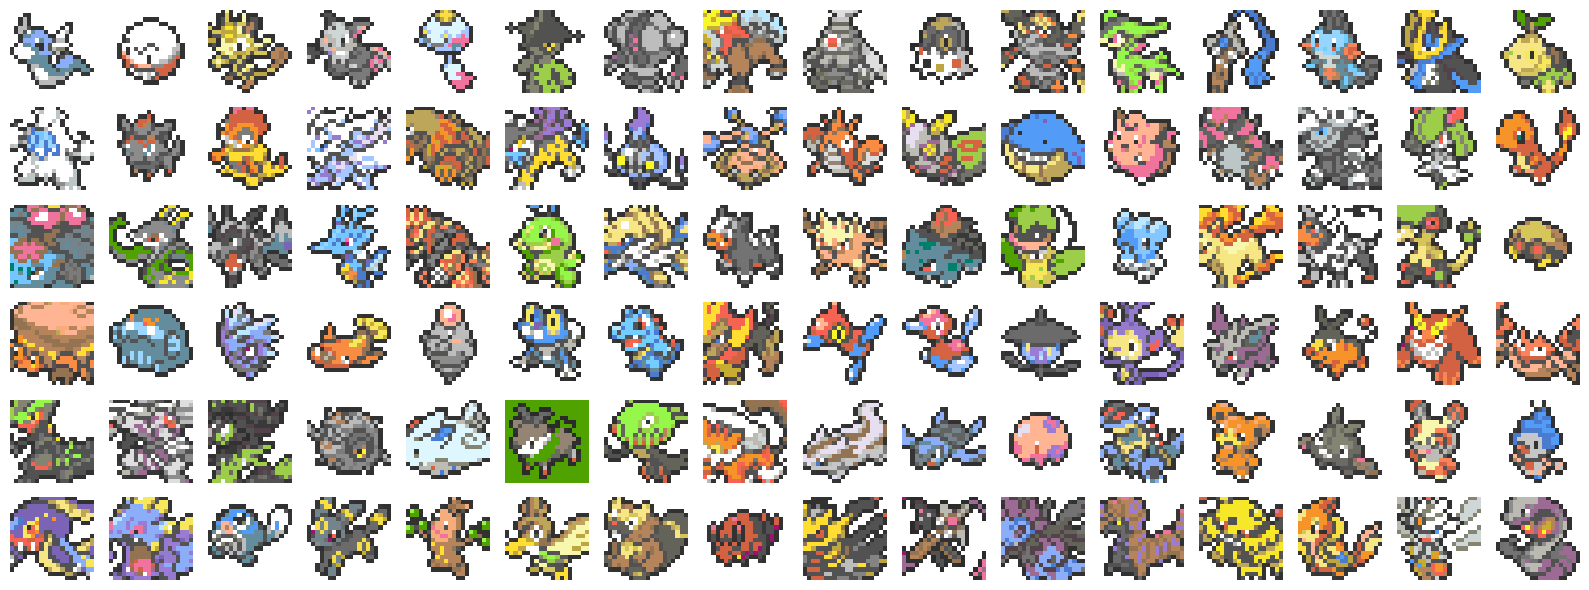

In [7]:
# Visualize train images
train_images = [pixel_to_image(data["pixel_color"], colormap) for data in pokemon_dataset["train"]]
show_images(train_images)

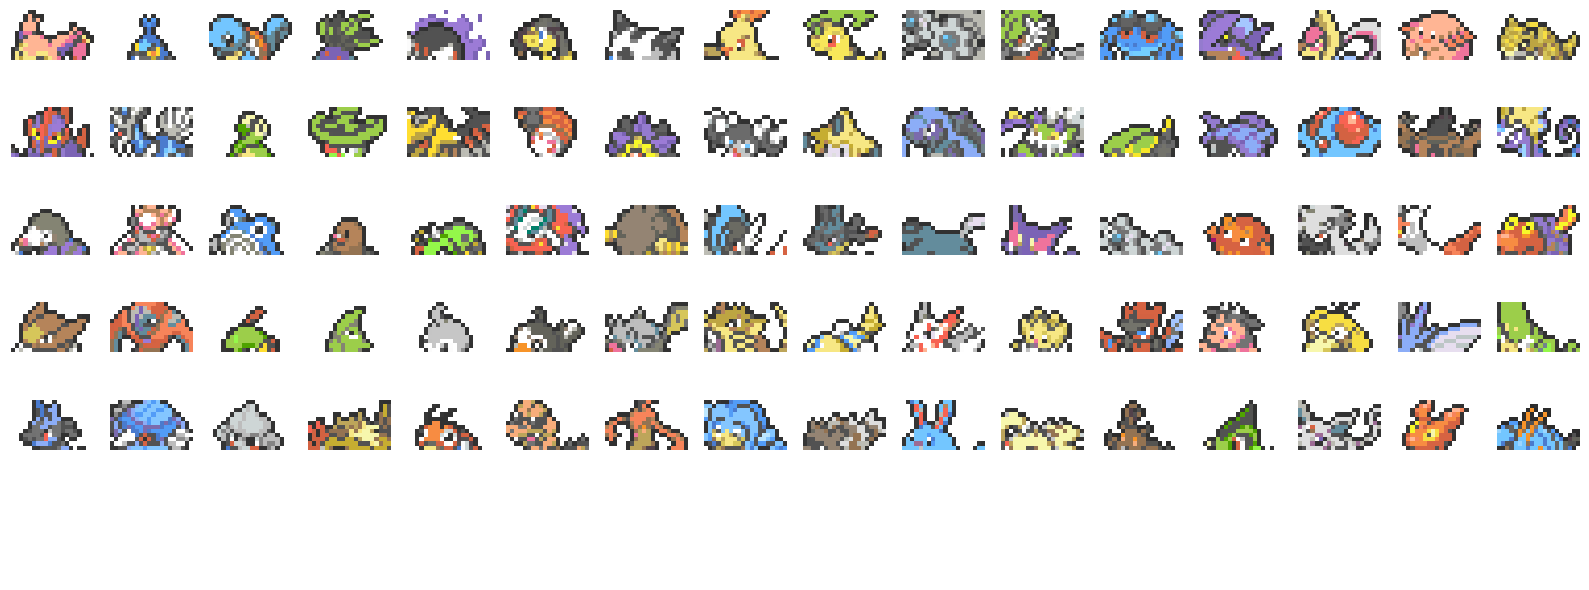

In [8]:
# Visualize test images
test_images = [pixel_to_image(data["pixel_color"], colormap) for data in pokemon_dataset["test"]]
show_images(test_images)

# Prepare Model

### Model Configuration
Here, we define the model configuration, including the architecture and key hyperparameters such as the number of attention heads, layers, embedding size, and more.


In [ ]:
# Define Mistral model configuration
from transformers import MistralConfig

config_dict = {
    "vocab_size": num_classes,           # Number of unique tokens in vocabulary
    "hidden_size": 128,                  # Embedding dimension
    "num_hidden_layers": 4,              # Number of transformer layers
    "num_attention_heads": 4,            # Number of attention heads
    "num_key_value_heads": 4,            # Same as attention heads to avoid the dimension mismatch
    "intermediate_size": 512,            # Size of feedforward layer
    "hidden_act": "silu",                # Activation function (SiLU works well with Mistral)
    "max_position_embeddings": 400,      # Maximum sequence length
    "initializer_range": 0.02,           # Weight initialization range
    "rms_norm_eps": 1e-6,                # Layer normalization epsilon
    "use_cache": True,                   # Whether to use past key/values for faster decoding
    "pad_token_id": None,                # No padding token
    "bos_token_id": None,                # No beginning of sequence token
    "eos_token_id": None,                # No end of sequence token
    "attention_dropout": 0.0,            # Attention dropout probability
    "sliding_window": None               # No sliding window attention (use full attention)
}

# Create config object from dictionary
config = MistralConfig(**config_dict)


### Load Model

In [10]:
# Load the model using the configuration defined above
model = AutoModelForCausalLM.from_config(config)

print(model)

# Count trainable parameters
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Trainable Parameters: {trainable_params:,}")

MistralForCausalLM(
  (model): MistralModel(
    (embed_tokens): Embedding(167, 128)
    (layers): ModuleList(
      (0-3): 4 x MistralDecoderLayer(
        (self_attn): MistralAttention(
          (q_proj): Linear(in_features=128, out_features=128, bias=False)
          (k_proj): Linear(in_features=128, out_features=128, bias=False)
          (v_proj): Linear(in_features=128, out_features=128, bias=False)
          (o_proj): Linear(in_features=128, out_features=128, bias=False)
        )
        (mlp): MistralMLP(
          (gate_proj): Linear(in_features=128, out_features=512, bias=False)
          (up_proj): Linear(in_features=128, out_features=512, bias=False)
          (down_proj): Linear(in_features=512, out_features=128, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): MistralRMSNorm((128,), eps=1e-06)
        (post_attention_layernorm): MistralRMSNorm((128,), eps=1e-06)
      )
    )
    (norm): MistralRMSNorm((128,), eps=1e-06)
    (rotary_emb): Mist

# Train and Inference

### Training Arguments
Here, we define the number of epochs for training, the learning rate, the optimizer, and the loss function.
*   Hint 3: Adjust the number of epochs and learning rate here to improve performance.

In [11]:
# Training Parameters
epochs = 50                                      # Number of training epochs
learning_rate = 1e-3                                 # Learning rate for optimizer
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")  # Use Metal Performance Shaders (MPS) if available
device = torch.device("cuda" if torch.cuda.is_available() else device)        # Check if CUDA is available for GPU
print(f"Using device: {device}")
save_dir = "checkpoints"                               # Directory to save model checkpoints

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()                          # Loss function for classification tasks
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.1) # AdamW optimizer with weight decay

Using device: mps


### Save Model Function

In [12]:
def save_model(model: torch.nn.Module, optimizer: torch.optim.Optimizer, epoch: int, loss: float, save_dir: str, filename: str = "best_model.pth") -> None:
    """
    Saves the model state, optimizer state, current epoch, and loss to a specified directory.

    Args:
        model (torch.nn.Module): The PyTorch model to be saved.
        optimizer (torch.optim.Optimizer): The optimizer whose state will be saved.
        epoch (int): The current epoch number (used for checkpointing).
        loss (float): The current loss value to track model performance.
        save_dir (str): The directory where the model checkpoint will be saved.
        filename (str, optional): The name of the file to save the model. Defaults to "best_model.pth".

    Returns:
        None
    """
    # Construct the full path for saving the model checkpoint
    save_path = os.path.join(save_dir, filename)

    # Save the model, optimizer state, and additional metadata (epoch and loss)
    torch.save({
        'epoch': epoch + 1,                # Save epoch + 1 for easier tracking
        'model_state_dict': model.state_dict(),       # Save model weights
        'optimizer_state_dict': optimizer.state_dict(),  # Save optimizer state (important for resuming training)
        'loss': loss                     # Save the current loss value
    }, save_path)

    # Print a confirmation message indicating the model has been saved
    print(f"Model saved at {save_path} (Loss: {loss:.4f}, Epoch: {epoch + 1})")

### Train

We save the checkpoint with the lowest training loss since validation set reconstruction accuracy doesn't directly reflect the model's image generation quality.

In [ ]:
# Create save directory if it doesn't exist
os.makedirs(save_dir, exist_ok=True)
# Initialize best loss as positive infinity for comparison during model checkpointing
best_loss: float = float('inf')
# Move model to the appropriate device (GPU or CPU)
model.to(device)

# Set up learning rate scheduler for better convergence
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min',
    factor=0.5,
    patience=3,
    verbose=True
)

# Initialize lists to track metrics
train_losses = []
validation_accuracies = []

# Training Loop
for epoch in range(epochs):
    model.train()  # Set the model to training mode
    epoch_loss = 0  # Initialize the epoch loss

    # Iterate over training data batches
    for input_ids, labels in tqdm(train_dataloader, desc=f"Training Epoch {epoch + 1}/{epochs}"):
        input_ids, labels = input_ids.to(device), labels.to(device)  # Move data to the same device as the model

        # Forward pass through the model to get logits (output probabilities)
        outputs = model(input_ids=input_ids).logits.view(-1, config.vocab_size)
        labels = labels.view(-1)  # Flatten labels to match logits shape

        # Calculate loss using CrossEntropyLoss
        loss = criterion(outputs, labels)

        # Backpropagation and optimizer step
        optimizer.zero_grad()  # Reset gradients to zero
        loss.backward()     # Compute gradients
        
        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()     # Update model weights

        # Accumulate the loss for the epoch
        epoch_loss += loss.item()

    # Compute average epoch loss
    avg_epoch_loss = epoch_loss / len(train_dataloader)
    train_losses.append(avg_epoch_loss)  # Track training loss
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_epoch_loss:.4f}")

    # Evaluation Loop (Validation)
    model.eval()      # Set the model to evaluation mode (disables dropout, etc.)
    total_accuracy = 0  # Initialize total accuracy
    num_batches = 0   # Initialize batch counter

    with torch.no_grad():  # Disable gradient calculation for validation
        # Iterate over validation data batches
        for inputs, labels in tqdm(dev_dataloader, desc="Evaluating"):
            inputs, labels = inputs.to(device), labels.to(device)  # Move validation data to device
            attention_mask = torch.ones_like(inputs)          # Attention mask to ensure valid token positions

            # Perform batch inference using the model
            generated_outputs = model.generate(inputs, attention_mask=attention_mask, max_length=400)

            # Extract the last 160 tokens from generated outputs and labels
            generated_outputs = generated_outputs[:, -160:]

            # Calculate accuracy for the batch
            accuracy = (generated_outputs == labels).float().mean().item()
            total_accuracy += accuracy
            num_batches += 1

    # Compute average reconstruction accuracy for the epoch
    avg_accuracy = total_accuracy / num_batches
    validation_accuracies.append(avg_accuracy)  # Track validation accuracy
    print(f"Epoch {epoch + 1}/{epochs}, Reconstruction Accuracy: {avg_accuracy:.4f}")

    # Update learning rate based on loss
    scheduler.step(avg_epoch_loss)

    # If the current epoch loss is better (lower) than the best loss, save the model
    if avg_epoch_loss < best_loss:
        best_loss = avg_epoch_loss                   # Update best loss
        save_model(model, optimizer, epoch, best_loss, save_dir)  # Save the model with the best loss
        
    # Early stopping check (optional)
    if epoch > 5 and all(train_losses[-1] > train_losses[-i-1] for i in range(3)):
        print("Early stopping due to increasing training loss for 3 consecutive epochs")
        break

/Users/matt/Programming/2025-spring/ML/.venv/lib/python3.13/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Training Epoch 1/50: 100%|██████████| 40/40 [00:04<00:00,  8.15it/s]


Epoch 1/50, Loss: 3.4544


Evaluating: 100%|██████████| 5/5 [00:10<00:00,  2.07s/it]


Epoch 1/50, Reconstruction Accuracy: 0.3638
Model saved at checkpoints/best_model.pth (Loss: 3.4544, Epoch: 1)


Training Epoch 2/50: 100%|██████████| 40/40 [00:04<00:00,  9.27it/s]


Epoch 2/50, Loss: 2.5384


Evaluating: 100%|██████████| 5/5 [00:07<00:00,  1.52s/it]


Epoch 2/50, Reconstruction Accuracy: 0.3702
Model saved at checkpoints/best_model.pth (Loss: 2.5384, Epoch: 2)


Training Epoch 3/50: 100%|██████████| 40/40 [00:04<00:00,  9.36it/s]


Epoch 3/50, Loss: 2.0399


Evaluating: 100%|██████████| 5/5 [00:07<00:00,  1.50s/it]


Epoch 3/50, Reconstruction Accuracy: 0.3639
Model saved at checkpoints/best_model.pth (Loss: 2.0399, Epoch: 3)


Training Epoch 4/50: 100%|██████████| 40/40 [00:04<00:00,  9.40it/s]


Epoch 4/50, Loss: 1.7845


Evaluating: 100%|██████████| 5/5 [00:07<00:00,  1.51s/it]


Epoch 4/50, Reconstruction Accuracy: 0.3523
Model saved at checkpoints/best_model.pth (Loss: 1.7845, Epoch: 4)


Training Epoch 5/50: 100%|██████████| 40/40 [00:04<00:00,  9.42it/s]


Epoch 5/50, Loss: 1.6556


Evaluating: 100%|██████████| 5/5 [00:07<00:00,  1.54s/it]


Epoch 5/50, Reconstruction Accuracy: 0.2956
Model saved at checkpoints/best_model.pth (Loss: 1.6556, Epoch: 5)


Training Epoch 6/50: 100%|██████████| 40/40 [00:04<00:00,  9.41it/s]


Epoch 6/50, Loss: 1.5642


Evaluating: 100%|██████████| 5/5 [00:07<00:00,  1.59s/it]


Epoch 6/50, Reconstruction Accuracy: 0.3364
Model saved at checkpoints/best_model.pth (Loss: 1.5642, Epoch: 6)


Training Epoch 7/50: 100%|██████████| 40/40 [00:04<00:00,  9.42it/s]


Epoch 7/50, Loss: 1.4930


Evaluating: 100%|██████████| 5/5 [00:07<00:00,  1.57s/it]


Epoch 7/50, Reconstruction Accuracy: 0.3261
Model saved at checkpoints/best_model.pth (Loss: 1.4930, Epoch: 7)


Training Epoch 8/50: 100%|██████████| 40/40 [00:04<00:00,  9.28it/s]


Epoch 8/50, Loss: 1.4453


Evaluating: 100%|██████████| 5/5 [00:07<00:00,  1.52s/it]


Epoch 8/50, Reconstruction Accuracy: 0.3613
Model saved at checkpoints/best_model.pth (Loss: 1.4453, Epoch: 8)


Training Epoch 9/50: 100%|██████████| 40/40 [00:04<00:00,  9.33it/s]


Epoch 9/50, Loss: 1.4144


Evaluating: 100%|██████████| 5/5 [00:07<00:00,  1.54s/it]


Epoch 9/50, Reconstruction Accuracy: 0.2642
Model saved at checkpoints/best_model.pth (Loss: 1.4144, Epoch: 9)


Training Epoch 10/50: 100%|██████████| 40/40 [00:04<00:00,  9.36it/s]


Epoch 10/50, Loss: 1.3749


Evaluating: 100%|██████████| 5/5 [00:07<00:00,  1.50s/it]


Epoch 10/50, Reconstruction Accuracy: 0.2874
Model saved at checkpoints/best_model.pth (Loss: 1.3749, Epoch: 10)


Training Epoch 11/50: 100%|██████████| 40/40 [00:04<00:00,  9.41it/s]


Epoch 11/50, Loss: 1.3446


Evaluating: 100%|██████████| 5/5 [00:07<00:00,  1.48s/it]


Epoch 11/50, Reconstruction Accuracy: 0.3316
Model saved at checkpoints/best_model.pth (Loss: 1.3446, Epoch: 11)


Training Epoch 12/50: 100%|██████████| 40/40 [00:04<00:00,  9.45it/s]


Epoch 12/50, Loss: 1.3228


Evaluating: 100%|██████████| 5/5 [00:07<00:00,  1.55s/it]


Epoch 12/50, Reconstruction Accuracy: 0.3395
Model saved at checkpoints/best_model.pth (Loss: 1.3228, Epoch: 12)


Training Epoch 13/50: 100%|██████████| 40/40 [00:04<00:00,  9.37it/s]


Epoch 13/50, Loss: 1.2934


Evaluating: 100%|██████████| 5/5 [00:07<00:00,  1.47s/it]


Epoch 13/50, Reconstruction Accuracy: 0.3555
Model saved at checkpoints/best_model.pth (Loss: 1.2934, Epoch: 13)


Training Epoch 14/50: 100%|██████████| 40/40 [00:04<00:00,  9.35it/s]


Epoch 14/50, Loss: 1.2541


Evaluating: 100%|██████████| 5/5 [00:07<00:00,  1.55s/it]


Epoch 14/50, Reconstruction Accuracy: 0.3262
Model saved at checkpoints/best_model.pth (Loss: 1.2541, Epoch: 14)


Training Epoch 15/50: 100%|██████████| 40/40 [00:04<00:00,  9.31it/s]


Epoch 15/50, Loss: 1.2264


Evaluating: 100%|██████████| 5/5 [00:07<00:00,  1.49s/it]


Epoch 15/50, Reconstruction Accuracy: 0.3050
Model saved at checkpoints/best_model.pth (Loss: 1.2264, Epoch: 15)


Training Epoch 16/50: 100%|██████████| 40/40 [00:04<00:00,  9.31it/s]


Epoch 16/50, Loss: 1.2032


Evaluating: 100%|██████████| 5/5 [00:07<00:00,  1.56s/it]


Epoch 16/50, Reconstruction Accuracy: 0.3523
Model saved at checkpoints/best_model.pth (Loss: 1.2032, Epoch: 16)


Training Epoch 17/50: 100%|██████████| 40/40 [00:04<00:00,  9.37it/s]


Epoch 17/50, Loss: 1.1739


Evaluating: 100%|██████████| 5/5 [00:07<00:00,  1.47s/it]


Epoch 17/50, Reconstruction Accuracy: 0.3640
Model saved at checkpoints/best_model.pth (Loss: 1.1739, Epoch: 17)


Training Epoch 18/50: 100%|██████████| 40/40 [00:04<00:00,  9.35it/s]


Epoch 18/50, Loss: 1.1528


Evaluating: 100%|██████████| 5/5 [00:07<00:00,  1.55s/it]


Epoch 18/50, Reconstruction Accuracy: 0.3695
Model saved at checkpoints/best_model.pth (Loss: 1.1528, Epoch: 18)


Training Epoch 19/50: 100%|██████████| 40/40 [00:04<00:00,  9.40it/s]


Epoch 19/50, Loss: 1.1286


Evaluating: 100%|██████████| 5/5 [00:07<00:00,  1.52s/it]


Epoch 19/50, Reconstruction Accuracy: 0.3202
Model saved at checkpoints/best_model.pth (Loss: 1.1286, Epoch: 19)


Training Epoch 20/50: 100%|██████████| 40/40 [00:04<00:00,  9.40it/s]


Epoch 20/50, Loss: 1.1073


Evaluating: 100%|██████████| 5/5 [00:07<00:00,  1.52s/it]


Epoch 20/50, Reconstruction Accuracy: 0.3716
Model saved at checkpoints/best_model.pth (Loss: 1.1073, Epoch: 20)


Training Epoch 21/50: 100%|██████████| 40/40 [00:04<00:00,  9.27it/s]


Epoch 21/50, Loss: 1.0769


Evaluating: 100%|██████████| 5/5 [00:07<00:00,  1.52s/it]


Epoch 21/50, Reconstruction Accuracy: 0.3448
Model saved at checkpoints/best_model.pth (Loss: 1.0769, Epoch: 21)


Training Epoch 22/50: 100%|██████████| 40/40 [00:04<00:00,  9.33it/s]


Epoch 22/50, Loss: 1.0570


Evaluating: 100%|██████████| 5/5 [00:07<00:00,  1.52s/it]


Epoch 22/50, Reconstruction Accuracy: 0.3454
Model saved at checkpoints/best_model.pth (Loss: 1.0570, Epoch: 22)


Training Epoch 23/50: 100%|██████████| 40/40 [00:04<00:00,  9.38it/s]


Epoch 23/50, Loss: 1.0253


Evaluating: 100%|██████████| 5/5 [00:07<00:00,  1.49s/it]


Epoch 23/50, Reconstruction Accuracy: 0.3365
Model saved at checkpoints/best_model.pth (Loss: 1.0253, Epoch: 23)


Training Epoch 24/50: 100%|██████████| 40/40 [00:04<00:00,  9.36it/s]


Epoch 24/50, Loss: 0.9963


Evaluating: 100%|██████████| 5/5 [00:07<00:00,  1.57s/it]


Epoch 24/50, Reconstruction Accuracy: 0.3370
Model saved at checkpoints/best_model.pth (Loss: 0.9963, Epoch: 24)


Training Epoch 25/50: 100%|██████████| 40/40 [00:04<00:00,  9.27it/s]


Epoch 25/50, Loss: 0.9608


Evaluating: 100%|██████████| 5/5 [00:07<00:00,  1.50s/it]


Epoch 25/50, Reconstruction Accuracy: 0.3634
Model saved at checkpoints/best_model.pth (Loss: 0.9608, Epoch: 25)


Training Epoch 26/50: 100%|██████████| 40/40 [00:04<00:00,  9.36it/s]


Epoch 26/50, Loss: 0.9278


Evaluating: 100%|██████████| 5/5 [00:07<00:00,  1.53s/it]


Epoch 26/50, Reconstruction Accuracy: 0.3731
Model saved at checkpoints/best_model.pth (Loss: 0.9278, Epoch: 26)


Training Epoch 27/50: 100%|██████████| 40/40 [00:04<00:00,  9.28it/s]


Epoch 27/50, Loss: 0.9022


Evaluating: 100%|██████████| 5/5 [00:07<00:00,  1.51s/it]


Epoch 27/50, Reconstruction Accuracy: 0.3248
Model saved at checkpoints/best_model.pth (Loss: 0.9022, Epoch: 27)


Training Epoch 28/50: 100%|██████████| 40/40 [00:04<00:00,  9.22it/s]


Epoch 28/50, Loss: 0.8647


Evaluating: 100%|██████████| 5/5 [00:07<00:00,  1.49s/it]


Epoch 28/50, Reconstruction Accuracy: 0.3403
Model saved at checkpoints/best_model.pth (Loss: 0.8647, Epoch: 28)


Training Epoch 29/50: 100%|██████████| 40/40 [00:04<00:00,  9.38it/s]


Epoch 29/50, Loss: 0.8331


Evaluating: 100%|██████████| 5/5 [00:07<00:00,  1.49s/it]


Epoch 29/50, Reconstruction Accuracy: 0.3230
Model saved at checkpoints/best_model.pth (Loss: 0.8331, Epoch: 29)


Training Epoch 30/50: 100%|██████████| 40/40 [00:04<00:00,  9.31it/s]


Epoch 30/50, Loss: 0.8075


Evaluating: 100%|██████████| 5/5 [00:07<00:00,  1.53s/it]


Epoch 30/50, Reconstruction Accuracy: 0.3324
Model saved at checkpoints/best_model.pth (Loss: 0.8075, Epoch: 30)


Training Epoch 31/50: 100%|██████████| 40/40 [00:04<00:00,  9.09it/s]


Epoch 31/50, Loss: 0.7709


Evaluating: 100%|██████████| 5/5 [00:07<00:00,  1.49s/it]


Epoch 31/50, Reconstruction Accuracy: 0.2971
Model saved at checkpoints/best_model.pth (Loss: 0.7709, Epoch: 31)


Training Epoch 32/50: 100%|██████████| 40/40 [00:04<00:00,  9.33it/s]


Epoch 32/50, Loss: 0.7456


Evaluating: 100%|██████████| 5/5 [00:07<00:00,  1.46s/it]


Epoch 32/50, Reconstruction Accuracy: 0.3464
Model saved at checkpoints/best_model.pth (Loss: 0.7456, Epoch: 32)


Training Epoch 33/50: 100%|██████████| 40/40 [00:04<00:00,  9.35it/s]


Epoch 33/50, Loss: 0.7105


Evaluating: 100%|██████████| 5/5 [00:07<00:00,  1.46s/it]


Epoch 33/50, Reconstruction Accuracy: 0.3348
Model saved at checkpoints/best_model.pth (Loss: 0.7105, Epoch: 33)


Training Epoch 34/50: 100%|██████████| 40/40 [00:04<00:00,  9.44it/s]


Epoch 34/50, Loss: 0.6780


Evaluating: 100%|██████████| 5/5 [00:07<00:00,  1.51s/it]


Epoch 34/50, Reconstruction Accuracy: 0.3418
Model saved at checkpoints/best_model.pth (Loss: 0.6780, Epoch: 34)


Training Epoch 35/50: 100%|██████████| 40/40 [00:04<00:00,  9.37it/s]


Epoch 35/50, Loss: 0.6510


Evaluating: 100%|██████████| 5/5 [00:07<00:00,  1.51s/it]


Epoch 35/50, Reconstruction Accuracy: 0.3246
Model saved at checkpoints/best_model.pth (Loss: 0.6510, Epoch: 35)


Training Epoch 36/50: 100%|██████████| 40/40 [00:04<00:00,  9.20it/s]


Epoch 36/50, Loss: 0.6229


Evaluating: 100%|██████████| 5/5 [00:07<00:00,  1.50s/it]


Epoch 36/50, Reconstruction Accuracy: 0.3261
Model saved at checkpoints/best_model.pth (Loss: 0.6229, Epoch: 36)


Training Epoch 37/50: 100%|██████████| 40/40 [00:04<00:00,  9.17it/s]


Epoch 37/50, Loss: 0.6014


Evaluating: 100%|██████████| 5/5 [00:07<00:00,  1.53s/it]


Epoch 37/50, Reconstruction Accuracy: 0.3083
Model saved at checkpoints/best_model.pth (Loss: 0.6014, Epoch: 37)


Training Epoch 38/50: 100%|██████████| 40/40 [00:04<00:00,  9.34it/s]


Epoch 38/50, Loss: 0.5673


Evaluating: 100%|██████████| 5/5 [00:08<00:00,  1.65s/it]


Epoch 38/50, Reconstruction Accuracy: 0.3115
Model saved at checkpoints/best_model.pth (Loss: 0.5673, Epoch: 38)


Training Epoch 39/50: 100%|██████████| 40/40 [00:04<00:00,  9.15it/s]


Epoch 39/50, Loss: 0.5421


Evaluating: 100%|██████████| 5/5 [00:07<00:00,  1.50s/it]


Epoch 39/50, Reconstruction Accuracy: 0.3430
Model saved at checkpoints/best_model.pth (Loss: 0.5421, Epoch: 39)


Training Epoch 40/50: 100%|██████████| 40/40 [00:04<00:00,  9.16it/s]


Epoch 40/50, Loss: 0.5324


Evaluating: 100%|██████████| 5/5 [00:07<00:00,  1.52s/it]


Epoch 40/50, Reconstruction Accuracy: 0.3459
Model saved at checkpoints/best_model.pth (Loss: 0.5324, Epoch: 40)


Training Epoch 41/50: 100%|██████████| 40/40 [00:04<00:00,  8.93it/s]


Epoch 41/50, Loss: 0.5041


Evaluating: 100%|██████████| 5/5 [00:08<00:00,  1.61s/it]


Epoch 41/50, Reconstruction Accuracy: 0.3825
Model saved at checkpoints/best_model.pth (Loss: 0.5041, Epoch: 41)


Training Epoch 42/50: 100%|██████████| 40/40 [00:04<00:00,  9.28it/s]


Epoch 42/50, Loss: 0.4804


Evaluating: 100%|██████████| 5/5 [00:07<00:00,  1.47s/it]


Epoch 42/50, Reconstruction Accuracy: 0.3289
Model saved at checkpoints/best_model.pth (Loss: 0.4804, Epoch: 42)


Training Epoch 43/50: 100%|██████████| 40/40 [00:04<00:00,  9.20it/s]


Epoch 43/50, Loss: 0.4638


Evaluating: 100%|██████████| 5/5 [00:07<00:00,  1.53s/it]


Epoch 43/50, Reconstruction Accuracy: 0.3383
Model saved at checkpoints/best_model.pth (Loss: 0.4638, Epoch: 43)


Training Epoch 44/50: 100%|██████████| 40/40 [00:04<00:00,  9.34it/s]


Epoch 44/50, Loss: 0.4484


Evaluating: 100%|██████████| 5/5 [00:07<00:00,  1.52s/it]


Epoch 44/50, Reconstruction Accuracy: 0.3339
Model saved at checkpoints/best_model.pth (Loss: 0.4484, Epoch: 44)


Training Epoch 45/50: 100%|██████████| 40/40 [00:04<00:00,  9.32it/s]


Epoch 45/50, Loss: 0.4235


Evaluating: 100%|██████████| 5/5 [00:07<00:00,  1.47s/it]


Epoch 45/50, Reconstruction Accuracy: 0.3473
Model saved at checkpoints/best_model.pth (Loss: 0.4235, Epoch: 45)


Training Epoch 46/50: 100%|██████████| 40/40 [00:04<00:00,  9.36it/s]


Epoch 46/50, Loss: 0.4093


Evaluating: 100%|██████████| 5/5 [00:07<00:00,  1.54s/it]


Epoch 46/50, Reconstruction Accuracy: 0.3434
Model saved at checkpoints/best_model.pth (Loss: 0.4093, Epoch: 46)


Training Epoch 47/50: 100%|██████████| 40/40 [00:04<00:00,  9.36it/s]


Epoch 47/50, Loss: 0.3945


Evaluating: 100%|██████████| 5/5 [00:07<00:00,  1.52s/it]


Epoch 47/50, Reconstruction Accuracy: 0.3062
Model saved at checkpoints/best_model.pth (Loss: 0.3945, Epoch: 47)


Training Epoch 48/50: 100%|██████████| 40/40 [00:04<00:00,  9.36it/s]


Epoch 48/50, Loss: 0.3834


Evaluating: 100%|██████████| 5/5 [00:07<00:00,  1.54s/it]


Epoch 48/50, Reconstruction Accuracy: 0.2954
Model saved at checkpoints/best_model.pth (Loss: 0.3834, Epoch: 48)


Training Epoch 49/50: 100%|██████████| 40/40 [00:04<00:00,  9.26it/s]


Epoch 49/50, Loss: 0.3652


Evaluating: 100%|██████████| 5/5 [00:07<00:00,  1.56s/it]


Epoch 49/50, Reconstruction Accuracy: 0.3267
Model saved at checkpoints/best_model.pth (Loss: 0.3652, Epoch: 49)


Training Epoch 50/50: 100%|██████████| 40/40 [00:04<00:00,  9.32it/s]


Epoch 50/50, Loss: 0.3470


Evaluating: 100%|██████████| 5/5 [00:07<00:00,  1.55s/it]

Epoch 50/50, Reconstruction Accuracy: 0.3396
Model saved at checkpoints/best_model.pth (Loss: 0.3470, Epoch: 50)


### Inference

In [14]:
# Load the best model from the saved checkpoint
best_model_path = os.path.join(save_dir, "best_model.pth")              # Path to the best model checkpoint
checkpoint = torch.load(best_model_path, weights_only=True, map_location=device)  # Load checkpoint from the file
model.load_state_dict(checkpoint["model_state_dict"])                  # Load the model weights from checkpoint
model.eval()                                        # Set the model to evaluation mode (disables dropout, etc.)

# Testing Loop with Batch Inference
results: list = []  # List to store the generated sequences from the model

with torch.no_grad():  # Disable gradient calculations for inference
    # Iterate over test data in batches
    for inputs in tqdm(test_dataloader, desc="Generating Outputs"):
        inputs = inputs.to(device)         # Move model to the appropriate device (GPU or CPU)
        attention_mask = torch.ones_like(inputs)  # Attention mask (ensure valid token positions)

        # Generate predictions for the entire batch
        generated_outputs = model.generate(inputs, attention_mask=attention_mask, max_length=400)

        # Convert batch outputs to a list and append to results
        batch_results = generated_outputs.cpu().numpy().tolist()
        results.extend(batch_results)  # Extend the results list with batch results

# Save the results to a file
output_file: str = "reconstructed_results.txt"  # File to save the output sequences
with open(output_file, "w") as f:
    # Write each sequence to the file
    for seq in results:
        f.write(" ".join(map(str, seq)) + "\n")

print(f"Reconstructed results saved to {output_file}")  # Confirmation message

Generating Outputs: 100%|██████████| 5/5 [00:07<00:00,  1.53s/it]

Reconstructed results saved to reconstructed_results.txt


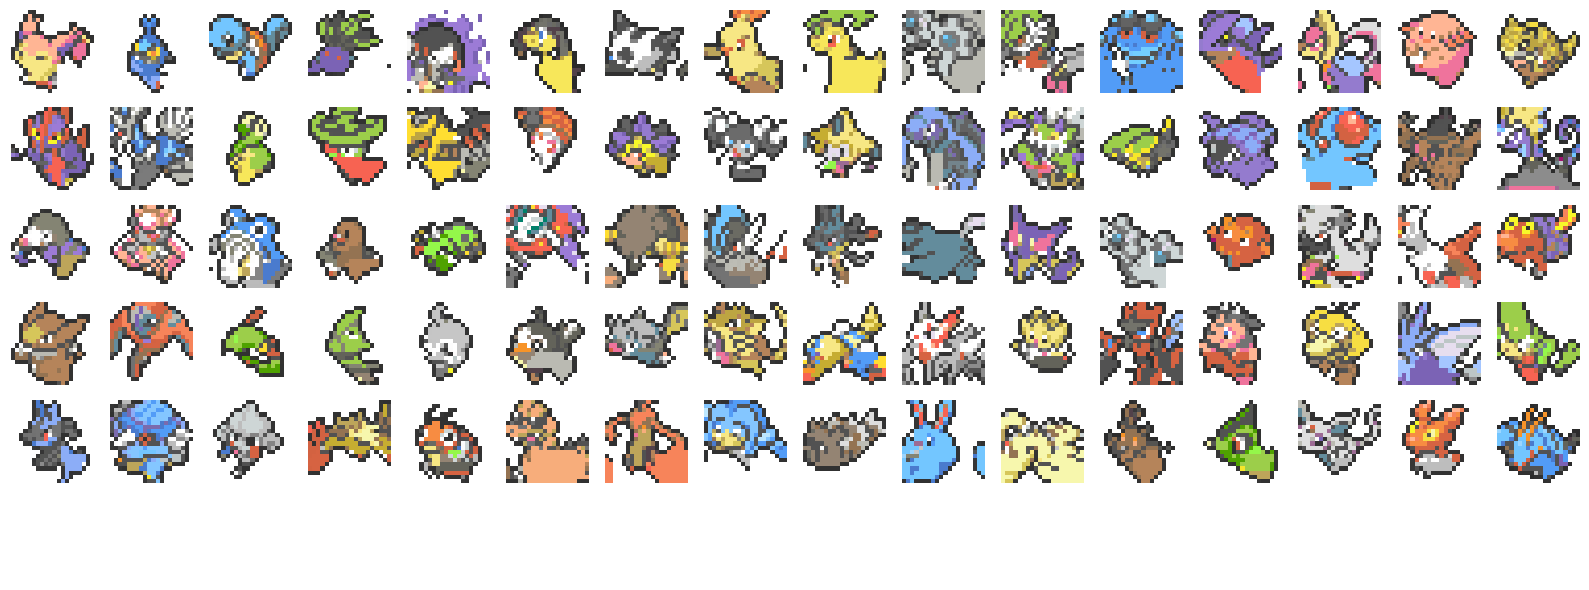

In [15]:
# Visualize generated test images
predicted_images = [pixel_to_image(sequence, colormap) for sequence in results]
show_images(predicted_images)